In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline
import time
import seaborn as sns
from pylab import rcParams
import datetime
from datetime import date
from sklearn.cluster import KMeans
from sklearn import preprocessing
import xgboost
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import class_weight
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
from sklearn.metrics import precision_recall_fscore_support, classification_report,precision_score,auc,accuracy_score, confusion_matrix, mean_squared_error
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

### Casino Users

In [2]:
casino_users = pd.read_csv('Casino Users.csv')
casino_users.head()

,UserProfileId,BirthDate,ZipCode,CountryName,Sex,Registration Date,City,CountryId,StatusSysname
0,1504977,1991-12-23 00:00:00.000,17342,Greece,M,2021-08-03 07:03:20.000,Athens,1,TEST
1,1258660,1991-07-06 00:00:00.000,15344,Greece,F,2021-01-15 09:03:21.000,pallini,1,TEST
2,1531613,1997-08-18 00:00:00.000,666666,Greece,M,2021-09-14 06:20:33.000,MENIDI,1,TEST
3,1278219,1985-02-01 00:00:00.000,14122,Greece,M,2021-01-28 14:14:02.000,Athens,1,TEST
4,1414194,1990-11-06 00:00:00.000,11636,Greece,M,2021-05-05 12:18:30.000,poli,1,TEST


In [3]:
# check for missing values
casino_users.isnull().sum()

UserProfileId        0
BirthDate            0
ZipCode              0
CountryName          0
Sex                  0
Registration Date    0
City                 0
CountryId            0
StatusSysname        0
dtype: int64

In [4]:
# remove dublicates
casino_users = casino_users.drop_duplicates()
casino_users

,UserProfileId,BirthDate,ZipCode,CountryName,Sex,Registration Date,City,CountryId,StatusSysname
0,1504977,1991-12-23 00:00:00.000,17342,Greece,M,2021-08-03 07:03:20.000,Athens,1,TEST
1,1258660,1991-07-06 00:00:00.000,15344,Greece,F,2021-01-15 09:03:21.000,pallini,1,TEST
2,1531613,1997-08-18 00:00:00.000,666666,Greece,M,2021-09-14 06:20:33.000,MENIDI,1,TEST
3,1278219,1985-02-01 00:00:00.000,14122,Greece,M,2021-01-28 14:14:02.000,Athens,1,TEST
4,1414194,1990-11-06 00:00:00.000,11636,Greece,M,2021-05-05 12:18:30.000,poli,1,TEST
...,...,...,...,...,...,...,...,...,...
10636,1699860,1998-03-17 00:00:00.000,57200,Greece,M,2022-03-05 14:59:56.000,Lagkadas,1,INACTIVE
10637,1684717,2000-05-05 00:00:00.000,118 52,Greece,M,2022-02-14 12:27:20.000,Athina,1,INACTIVE
10638,1527028,1999-04-18 00:00:00.000,56430,Greece,F,2021-09-08 13:17:49.000,Thessaloniki,1,INACTIVE
10639,1515759,1971-11-07 00:00:00.000,122 44,Greece,F,2021-08-22 08:55:01.000,Egaleo,1,INACTIVE


In [5]:
# keep only first record for each UserProfileId
casino_users = casino_users.groupby('UserProfileId').first().reset_index()
casino_users

,UserProfileId,BirthDate,ZipCode,CountryName,Sex,Registration Date,City,CountryId,StatusSysname
0,1248183,1991-04-11 00:00:00.000,15954,Greece,M,2021-01-08 12:07:29.000,kanto,1,TEST
1,1248186,1993-11-18 00:00:00.000,302 00,Greece,M,2021-01-08 12:08:14.000,mesologgi,1,TEST
2,1258660,1991-07-06 00:00:00.000,15344,Greece,F,2021-01-15 09:03:21.000,pallini,1,TEST
3,1267749,1986-09-19 00:00:00.000,10445,Greece,M,2021-01-21 12:01:04.000,Athens,1,TEST
4,1269209,1996-05-24 00:00:00.000,18544,Greece,F,2021-01-22 10:53:41.000,peiraias,1,TEST
...,...,...,...,...,...,...,...,...,...
6024,1716248,1989-09-24 00:00:00.000,712 02,Greece,F,2022-04-01 19:29:59.000,Iraklio,1,ACTIVE
6025,1716297,1993-06-10 00:00:00.000,13672,Greece,M,2022-04-01 22:33:00.000,Menidi,1,ACTIVE
6026,1716507,1978-10-16 00:00:00.000,55131,Greece,M,2022-04-02 15:28:00.000,kalamaria,1,ACTIVE
6027,1716671,1992-02-07 00:00:00.000,546 44,Greece,F,2022-04-02 23:34:29.000,Thessaloniki,1,ACTIVE


In [6]:
# convert dates to datetime objects

casino_users['BirthDate'] = pd.to_datetime(casino_users['BirthDate']) 

casino_users['Registration Date'] = pd.to_datetime(casino_users['Registration Date']) 
casino_users['Registration Date'] = casino_users['Registration Date'].dt.date
casino_users['Registration Date'] = pd.to_datetime(casino_users['Registration Date'], format="%Y/%m/%d")

casino_users

,UserProfileId,BirthDate,ZipCode,CountryName,Sex,Registration Date,City,CountryId,StatusSysname
0,1248183,1991-04-11,15954,Greece,M,2021-01-08,kanto,1,TEST
1,1248186,1993-11-18,302 00,Greece,M,2021-01-08,mesologgi,1,TEST
2,1258660,1991-07-06,15344,Greece,F,2021-01-15,pallini,1,TEST
3,1267749,1986-09-19,10445,Greece,M,2021-01-21,Athens,1,TEST
4,1269209,1996-05-24,18544,Greece,F,2021-01-22,peiraias,1,TEST
...,...,...,...,...,...,...,...,...,...
6024,1716248,1989-09-24,712 02,Greece,F,2022-04-01,Iraklio,1,ACTIVE
6025,1716297,1993-06-10,13672,Greece,M,2022-04-01,Menidi,1,ACTIVE
6026,1716507,1978-10-16,55131,Greece,M,2022-04-02,kalamaria,1,ACTIVE
6027,1716671,1992-02-07,546 44,Greece,F,2022-04-02,Thessaloniki,1,ACTIVE


In [7]:
# function for calculating user age using the date of birth
def from_dob_to_age(born):
    today = datetime.date.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))


# calculate age using the function above
casino_users['age'] = casino_users['BirthDate'].apply(lambda x: from_dob_to_age(x))
casino_users

,UserProfileId,BirthDate,ZipCode,CountryName,Sex,Registration Date,City,CountryId,StatusSysname,age
0,1248183,1991-04-11,15954,Greece,M,2021-01-08,kanto,1,TEST,31
1,1248186,1993-11-18,302 00,Greece,M,2021-01-08,mesologgi,1,TEST,28
2,1258660,1991-07-06,15344,Greece,F,2021-01-15,pallini,1,TEST,30
3,1267749,1986-09-19,10445,Greece,M,2021-01-21,Athens,1,TEST,35
4,1269209,1996-05-24,18544,Greece,F,2021-01-22,peiraias,1,TEST,26
...,...,...,...,...,...,...,...,...,...,...
6024,1716248,1989-09-24,712 02,Greece,F,2022-04-01,Iraklio,1,ACTIVE,32
6025,1716297,1993-06-10,13672,Greece,M,2022-04-01,Menidi,1,ACTIVE,29
6026,1716507,1978-10-16,55131,Greece,M,2022-04-02,kalamaria,1,ACTIVE,43
6027,1716671,1992-02-07,546 44,Greece,F,2022-04-02,Thessaloniki,1,ACTIVE,30


In [8]:
casino_users.groupby(['StatusSysname'])['StatusSysname'].count()

StatusSysname
ACTIVE      5937
INACTIVE      24
TEST          68
Name: StatusSysname, dtype: int64

In [9]:
# remove users having status = 'TEST'
casino_users = casino_users[casino_users['StatusSysname'] != 'TEST']
casino_users

,UserProfileId,BirthDate,ZipCode,CountryName,Sex,Registration Date,City,CountryId,StatusSysname,age
44,1503886,1988-12-01,Yo265lb,United Kingdom,M,2021-08-01,York,175,ACTIVE,33
45,1503909,1969-03-05,10443,Greece,M,2021-08-01,Athina,1,ACTIVE,53
46,1503959,1956-04-01,145 62,Greece,F,2021-08-01,Kifisia,1,ACTIVE,66
47,1503973,1999-09-16,70006,Greece,M,2021-08-01,Hrakleio,1,ACTIVE,22
48,1503986,1986-06-20,190 13,Greece,M,2021-08-01,Anavissos,1,ACTIVE,36
...,...,...,...,...,...,...,...,...,...,...
6024,1716248,1989-09-24,712 02,Greece,F,2022-04-01,Iraklio,1,ACTIVE,32
6025,1716297,1993-06-10,13672,Greece,M,2022-04-01,Menidi,1,ACTIVE,29
6026,1716507,1978-10-16,55131,Greece,M,2022-04-02,kalamaria,1,ACTIVE,43
6027,1716671,1992-02-07,546 44,Greece,F,2022-04-02,Thessaloniki,1,ACTIVE,30


In [10]:
casino_users.groupby(['StatusSysname'])['StatusSysname'].count()

StatusSysname
ACTIVE      5937
INACTIVE      24
Name: StatusSysname, dtype: int64

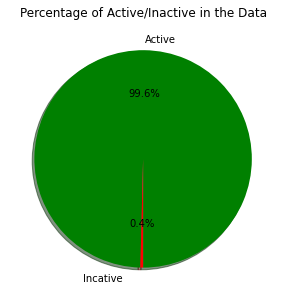

In [11]:
# Create plot with the percentage of each status
sizes = casino_users['StatusSysname'].value_counts(sort = True)
colors = ["green","red"] 
rcParams['figure.figsize'] = 5,5
labels = 'Active','Incative      '

plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=270,)
plt.title('Percentage of Active/Inactive in the Data')
plt.show()

In [12]:
casino_users.groupby(['Sex'])['Sex'].count()

Sex
F    1265
M    4696
Name: Sex, dtype: int64

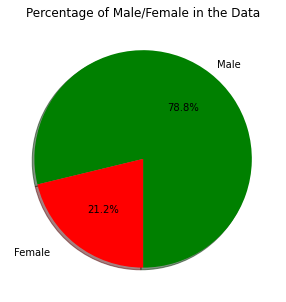

In [13]:
# Create plot with the percentage of each gender
sizes = casino_users['Sex'].value_counts(sort = True)
colors = ["green","red"] 
rcParams['figure.figsize'] = 5,5
labels = 'Male','Female      '

plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=270,)
plt.title('Percentage of Male/Female in the Data')
plt.show()

In [14]:
casino_users['age'].describe()

count    5961.000000
mean       34.286361
std        11.825679
min        18.000000
25%        25.000000
50%        31.000000
75%        42.000000
max        83.000000
Name: age, dtype: float64

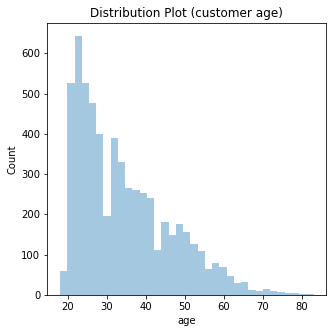

In [15]:
sns.distplot(casino_users['age'], kde = False)
plt.title('Distribution Plot (customer age)')
plt.ylabel('Count')
plt.show()

### Customer Wallet

In [16]:
customer_wallet = pd.read_csv('Customer Wallet.csv')
customer_wallet.head()

,WalletActionId,UserProfileId,Type,TypeSysname,Amount,MethodSysname,Created
0,29220192,1521781,1,DEPOSIT,100.0,DIASDTM,2021-10-10 19:16:58.297
1,29220298,1512213,1,DEPOSIT,10.0,VisaCard,2021-10-10 19:19:03.650
2,29221601,1520026,1,DEPOSIT,3.0,DIASDTM,2021-10-10 19:40:06.510
3,29222108,1550402,1,DEPOSIT,10.0,PSCPaysafeCard,2021-10-10 19:49:03.867
4,29203403,1550060,2,WITHDRAW,-17.5,VisaCard,2021-10-10 19:50:06.037


In [17]:
# check for missing values
customer_wallet.isnull().sum()

WalletActionId    0
UserProfileId     0
Type              0
TypeSysname       0
Amount            0
MethodSysname     0
Created           0
dtype: int64

In [18]:
# remove dublicates
customer_wallet = customer_wallet.drop_duplicates()
customer_wallet

,WalletActionId,UserProfileId,Type,TypeSysname,Amount,MethodSysname,Created
0,29220192,1521781,1,DEPOSIT,100.0,DIASDTM,2021-10-10 19:16:58.297
1,29220298,1512213,1,DEPOSIT,10.0,VisaCard,2021-10-10 19:19:03.650
2,29221601,1520026,1,DEPOSIT,3.0,DIASDTM,2021-10-10 19:40:06.510
3,29222108,1550402,1,DEPOSIT,10.0,PSCPaysafeCard,2021-10-10 19:49:03.867
4,29203403,1550060,2,WITHDRAW,-17.5,VisaCard,2021-10-10 19:50:06.037
...,...,...,...,...,...,...,...
38289,29215354,1539733,2,WITHDRAW,-50.0,Envoy,2021-10-10 18:18:23.463
38290,29217096,1533860,1,DEPOSIT,10.0,PSCPaysafeCard,2021-10-10 18:27:54.083
38291,29217129,1530850,1,DEPOSIT,10.0,PSCPaysafeCard,2021-10-10 18:28:23.613
38292,29219860,1552084,1,DEPOSIT,5.0,PSCPaysafeCard,2021-10-10 19:10:55.810


In [19]:
# convert dates to datetime objects
customer_wallet['Created'] = pd.to_datetime(customer_wallet['Created']) 
customer_wallet['Created'] = customer_wallet['Created'].dt.date
customer_wallet['Created'] = pd.to_datetime(customer_wallet['Created'], format="%Y/%m/%d") 

customer_wallet.head()

,WalletActionId,UserProfileId,Type,TypeSysname,Amount,MethodSysname,Created
0,29220192,1521781,1,DEPOSIT,100.0,DIASDTM,2021-10-10
1,29220298,1512213,1,DEPOSIT,10.0,VisaCard,2021-10-10
2,29221601,1520026,1,DEPOSIT,3.0,DIASDTM,2021-10-10
3,29222108,1550402,1,DEPOSIT,10.0,PSCPaysafeCard,2021-10-10
4,29203403,1550060,2,WITHDRAW,-17.5,VisaCard,2021-10-10


### Casino Games

In [20]:
casino_games = pd.read_csv('Casino games.csv')
casino_games.head()

,Casino_Provider,UserID,IsJackpotWinID,IsFreeSpinID,Date,IsLiveID,Hold
0,Iforium,984532,0,0,2021-09-07,0,185.0
1,Nyx,1531182,0,0,2021-09-29,0,85.1
2,PragmaticPlay,1149364,0,0,2021-09-03,0,243.6
3,PlayNGo,1130140,0,1,2021-10-02,0,-218.4
4,PlayTech,1009509,0,0,2021-09-25,0,-5.4


In [21]:
# check for missing values
casino_games.isnull().sum()

Casino_Provider    0
UserID             0
IsJackpotWinID     0
IsFreeSpinID       0
Date               0
IsLiveID           0
Hold               0
dtype: int64

In [22]:
# remove dublicates
casino_games = casino_games.drop_duplicates()
casino_games

,Casino_Provider,UserID,IsJackpotWinID,IsFreeSpinID,Date,IsLiveID,Hold
0,Iforium,984532,0,0,2021-09-07,0,185.000000
1,Nyx,1531182,0,0,2021-09-29,0,85.100000
2,PragmaticPlay,1149364,0,0,2021-09-03,0,243.600000
3,PlayNGo,1130140,0,1,2021-10-02,0,-218.400000
4,PlayTech,1009509,0,0,2021-09-25,0,-5.400000
...,...,...,...,...,...,...,...
9823916,Iforium,1221060,0,0,2021-10-17,0,176.850000
9823917,PlayTech,1416165,0,0,2021-10-14,0,-2.400000
9823918,PlayTech,737214,0,0,2021-10-01,0,1248.300000
9823919,PragmaticPlay,1485488,0,1,2021-09-23,0,-17.480000


In [23]:
# convert dates to datetime objects
casino_games['Date'] = pd.to_datetime(casino_games['Date']) 
casino_games

,Casino_Provider,UserID,IsJackpotWinID,IsFreeSpinID,Date,IsLiveID,Hold
0,Iforium,984532,0,0,2021-09-07,0,185.000000
1,Nyx,1531182,0,0,2021-09-29,0,85.100000
2,PragmaticPlay,1149364,0,0,2021-09-03,0,243.600000
3,PlayNGo,1130140,0,1,2021-10-02,0,-218.400000
4,PlayTech,1009509,0,0,2021-09-25,0,-5.400000
...,...,...,...,...,...,...,...
9823916,Iforium,1221060,0,0,2021-10-17,0,176.850000
9823917,PlayTech,1416165,0,0,2021-10-14,0,-2.400000
9823918,PlayTech,737214,0,0,2021-10-01,0,1248.300000
9823919,PragmaticPlay,1485488,0,1,2021-09-23,0,-17.480000


In [24]:
casino_games['Date'].max() # max date

Timestamp('2021-11-01 00:00:00')

In [25]:
casino_games['Date'].min() # min date

Timestamp('2021-09-01 00:00:00')

In [26]:
casino_games['Date'].max() - casino_games['Date'].min()   # time window

Timedelta('61 days 00:00:00')

### Casino Analysis 

In [27]:
# join casino users with casino games
casino_games_casino_users_join = pd.merge(casino_users, casino_games, left_on=['UserProfileId'], right_on=['UserID'], how = 'inner')
casino_games_casino_users_join.head()

,UserProfileId,BirthDate,ZipCode,CountryName,Sex,Registration Date,City,CountryId,StatusSysname,age,Casino_Provider,UserID,IsJackpotWinID,IsFreeSpinID,Date,IsLiveID,Hold
0,1503909,1969-03-05,10443,Greece,M,2021-08-01,Athina,1,ACTIVE,53,NetEnt,1503909,0,0,2021-09-27,0,559.58
1,1503909,1969-03-05,10443,Greece,M,2021-08-01,Athina,1,ACTIVE,53,Iforium,1503909,0,0,2021-09-29,0,294.00
2,1503909,1969-03-05,10443,Greece,M,2021-08-01,Athina,1,ACTIVE,53,PragmaticPlay,1503909,0,0,2021-09-27,0,234.22
3,1503909,1969-03-05,10443,Greece,M,2021-08-01,Athina,1,ACTIVE,53,Nyx,1503909,0,0,2021-10-08,0,155.82
4,1503909,1969-03-05,10443,Greece,M,2021-08-01,Athina,1,ACTIVE,53,Iforium,1503909,0,0,2021-09-27,0,1274.00


In [28]:
Max_Date = pd.to_datetime('2021-11-01')
Min_Date = pd.to_datetime('2021-09-01')
Time_Window = 61


# group by provider and user
casino_groupby = casino_games_casino_users_join.groupby(['Casino_Provider', 'UserID']) 

Summary_Table = casino_groupby.agg(Total_Amount=pd.NamedAgg(column="Hold", aggfunc='sum'),
                                   Active_Days=pd.NamedAgg(column="Date", aggfunc='nunique'),
                                   Registration_Date=pd.NamedAgg(column="Registration Date", aggfunc='max')
                                   )


Summary_Table = Summary_Table.reset_index()

# calculate tenure and active days/tenure ratio
Summary_Table['Tenure'] = np.where( (Summary_Table['Registration_Date'] < Min_Date), Time_Window, (Max_Date - Summary_Table['Registration_Date']).dt.days)
Summary_Table['Active_Tenure_Ratio'] =  np.where( (Summary_Table['Tenure'] == 0), 0, (Summary_Table['Active_Days'] / Summary_Table['Tenure']))

# remove new customers
Summary_Table = Summary_Table[Summary_Table['Tenure'] > 0]

Summary_Table

,Casino_Provider,UserID,Total_Amount,Active_Days,Registration_Date,Tenure,Active_Tenure_Ratio
0,Edict,1505971,24468.268581,4,2021-08-04,61,0.065574
1,Edict,1506359,634.980141,8,2021-08-05,61,0.131148
2,Edict,1507880,-155.770683,16,2021-08-08,61,0.262295
3,Edict,1510411,56.892260,1,2021-08-13,61,0.016393
4,Edict,1511260,1083.523385,12,2021-08-14,61,0.196721
...,...,...,...,...,...,...,...
8530,Skywind,1569653,-993.200000,1,2021-10-27,5,0.200000
8531,Skywind,1570346,51.300000,1,2021-10-28,4,0.250000
8532,Skywind,1570988,-82.500000,1,2021-10-28,4,0.250000
8533,Skywind,1571724,19.580000,1,2021-10-29,3,0.333333


In [29]:
# get insights per provider

groupby_provider = Summary_Table.groupby(['Casino_Provider'])

Provider_Results = groupby_provider.agg(Total_Users=pd.NamedAgg(column="UserID", aggfunc='nunique'),
                                       Avg_Active_Days=pd.NamedAgg(column="Active_Days", aggfunc='mean'),
                                       Total_Active_Days=pd.NamedAgg(column="Active_Days", aggfunc='sum'),
                                       Total_Amount=pd.NamedAgg(column="Total_Amount", aggfunc='sum'),
                                       Avg_Active_Tenure_Ratio=pd.NamedAgg(column="Active_Tenure_Ratio", aggfunc='mean')
                                      )

Provider_Results = Provider_Results.reset_index()
Provider_Results = Provider_Results.sort_values(by='Total_Users', ascending=False)
Provider_Results['Avg_Amount_Per_User'] = Provider_Results['Total_Amount'] / Provider_Results['Total_Users']
Provider_Results['Avg_Amount_Per_Active_Day'] = Provider_Results['Total_Amount'] / Provider_Results['Total_Active_Days']
Provider_Results = Provider_Results.reset_index(drop=True)

Provider_Results

,Casino_Provider,Total_Users,Avg_Active_Days,Total_Active_Days,Total_Amount,Avg_Active_Tenure_Ratio,Avg_Amount_Per_User,Avg_Amount_Per_Active_Day
0,PlayTech,1232,11.103896,13680,5.116310e+06,0.302424,4152.849299,373.999294
1,PlayNGo,1203,8.910224,10719,6.756432e+05,0.239203,561.631903,63.032296
2,PragmaticPlay,1139,7.512730,8557,-7.786018e+04,0.201258,-68.358371,-9.099005
3,Nyx,1091,6.906508,7535,1.632502e+06,0.194638,1496.335396,216.655862
4,NetEnt,1006,4.611332,4639,1.836185e+05,0.129829,182.523404,39.581493
5,Iforium,1002,7.140719,7155,1.491421e+06,0.202284,1488.444514,208.444641
6,RedTiger,874,3.552632,3105,1.398593e+05,0.095277,160.022037,45.043240
7,Skywind,454,3.535242,1605,1.165182e+05,0.090279,256.647979,72.596998
8,Evolution,284,4.126761,1172,1.271278e+06,0.121343,4476.330461,1084.708064
9,MicroGaming,91,5.824176,530,2.709257e+05,0.137967,2977.205589,511.180582


### Customer Segmentation - RFM

In [30]:
casino_games

,Casino_Provider,UserID,IsJackpotWinID,IsFreeSpinID,Date,IsLiveID,Hold
0,Iforium,984532,0,0,2021-09-07,0,185.000000
1,Nyx,1531182,0,0,2021-09-29,0,85.100000
2,PragmaticPlay,1149364,0,0,2021-09-03,0,243.600000
3,PlayNGo,1130140,0,1,2021-10-02,0,-218.400000
4,PlayTech,1009509,0,0,2021-09-25,0,-5.400000
...,...,...,...,...,...,...,...
9823916,Iforium,1221060,0,0,2021-10-17,0,176.850000
9823917,PlayTech,1416165,0,0,2021-10-14,0,-2.400000
9823918,PlayTech,737214,0,0,2021-10-01,0,1248.300000
9823919,PragmaticPlay,1485488,0,1,2021-09-23,0,-17.480000


In [31]:
Min_Date = pd.to_datetime('2021-09-01')

casino_games['Date copy'] = casino_games['Date']

# get only customers who have been registered before the start of the time window (61 days)
Two_Whole_Months = casino_games_casino_users_join[casino_games_casino_users_join['Registration Date'] < Min_Date]
Two_Whole_Months['Date copy'] = Two_Whole_Months['Date']
Two_Whole_Months

,UserProfileId,BirthDate,ZipCode,CountryName,Sex,Registration Date,City,CountryId,StatusSysname,age,Casino_Provider,UserID,IsJackpotWinID,IsFreeSpinID,Date,IsLiveID,Hold,Date copy
0,1503909,1969-03-05,10443,Greece,M,2021-08-01,Athina,1,ACTIVE,53,NetEnt,1503909,0,0,2021-09-27,0,559.580000,2021-09-27
1,1503909,1969-03-05,10443,Greece,M,2021-08-01,Athina,1,ACTIVE,53,Iforium,1503909,0,0,2021-09-29,0,294.000000,2021-09-29
2,1503909,1969-03-05,10443,Greece,M,2021-08-01,Athina,1,ACTIVE,53,PragmaticPlay,1503909,0,0,2021-09-27,0,234.220000,2021-09-27
3,1503909,1969-03-05,10443,Greece,M,2021-08-01,Athina,1,ACTIVE,53,Nyx,1503909,0,0,2021-10-08,0,155.820000,2021-10-08
4,1503909,1969-03-05,10443,Greece,M,2021-08-01,Athina,1,ACTIVE,53,Iforium,1503909,0,0,2021-09-27,0,1274.000000,2021-09-27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29474,1522271,1988-03-22,N80bu,United Kingdom,F,2021-08-31,London,175,ACTIVE,34,MicroGaming,1522271,0,0,2021-09-20,0,127.338890,2021-09-20
29475,1522271,1988-03-22,N80bu,United Kingdom,F,2021-08-31,London,175,ACTIVE,34,Nyx,1522271,0,0,2021-09-02,0,37.309082,2021-09-02
29476,1522271,1988-03-22,N80bu,United Kingdom,F,2021-08-31,London,175,ACTIVE,34,PragmaticPlay,1522271,0,0,2021-09-17,0,167.788856,2021-09-17
29477,1522271,1988-03-22,N80bu,United Kingdom,F,2021-08-31,London,175,ACTIVE,34,Iforium,1522271,0,1,2021-10-14,0,-12.448426,2021-10-14


In [32]:
now = pd.to_datetime('2021-11-01') # max casino game date


# create 2 subgroups for 2 different time periods
First_Month = Two_Whole_Months[Two_Whole_Months['Date'] < '2021-10-01' ] # first month of casino
Second_Month = Two_Whole_Months[Two_Whole_Months['Date'] >= '2021-10-01'] # second month of casino


# calculate RFM metrics for the first month
RFM_First_Month=First_Month.groupby('UserID').agg({'Date': lambda x: (now - x.max()).days, # Recency
                                                   'Date copy': lambda x: len(x.unique()), # Frequency
                                                   'Hold': lambda x: x.sum()})   # Monetary 

RFM_First_Month = RFM_First_Month.reset_index()

RFM_First_Month.rename(columns={'Date': 'recency', 
                                'Date copy': 'frequency',
                                'Hold': 'amount'}, inplace=True)

RFM_table = RFM_First_Month.copy()
RFM_table

,UserID,recency,frequency,amount
0,1503909,33,15,20359.010000
1,1503973,32,20,1.260000
2,1503986,32,25,-2159.630000
3,1504041,58,3,0.550000
4,1504089,32,26,-464.730000
...,...,...,...,...
371,1522128,32,21,52083.840000
372,1522160,32,27,-0.360000
373,1522218,33,18,155.000000
374,1522269,60,1,1749.790000


#### K-Means Clustering 

In [33]:
# function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

##### Recency Clusters 

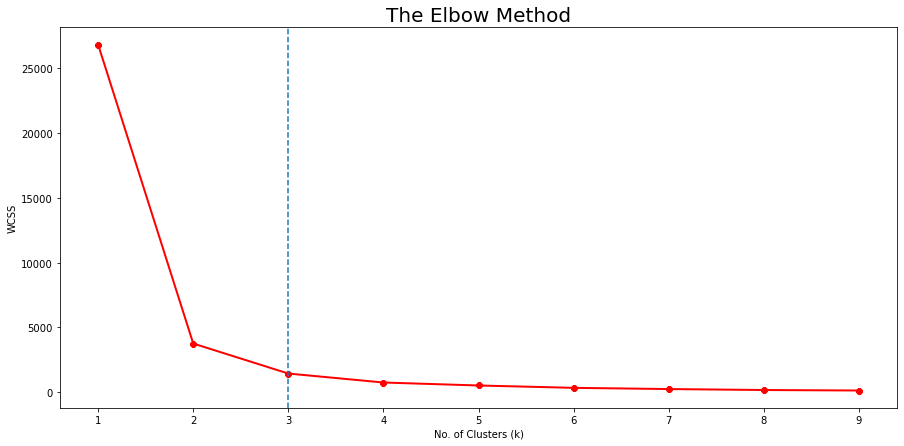

In [34]:
wcss=[]
clustering_data = RFM_table[['recency']]
for i in range(1,10):
    km = KMeans(i)
    km.fit(clustering_data)
    wcss.append(km.inertia_)

    
fig, ax = plt.subplots(figsize=(15,7))
ax = plt.plot(range(1,10),wcss, linewidth=2, color="red", marker ="8")
plt.axvline(x=3, ls='--')
plt.ylabel('WCSS')
plt.xlabel('No. of Clusters (k)')
plt.title('The Elbow Method', fontsize = 20)
plt.show()

In [35]:
# build 3 clusters for recency and add it to dataframe
kmeans = KMeans(n_clusters=3)
kmeans.fit(RFM_table[['recency']])
RFM_table['RecencyCluster'] = kmeans.predict(RFM_table[['recency']])

RFM_table = order_cluster('RecencyCluster', 'recency',RFM_table,False)

RFM_table

,UserID,recency,frequency,amount,RecencyCluster
0,1503909,33,15,20359.01,2
1,1503973,32,20,1.26,2
2,1503986,32,25,-2159.63,2
3,1504089,32,26,-464.73,2
4,1504120,35,2,2468.80,2
...,...,...,...,...,...
371,1517136,39,21,-34.58,1
372,1518267,40,10,5205.48,1
373,1519002,42,13,-125.59,1
374,1521647,41,3,2302.86,1


In [36]:
RFM_table.groupby('RecencyCluster')['recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,47.0,56.446809,3.126385,51.0,54.0,57.0,59.0,61.0
1,42.0,44.071429,3.402960,39.0,41.0,43.5,47.0,50.0
2,287.0,32.616725,1.342995,32.0,32.0,32.0,32.5,38.0


#### Frequency Clusters 

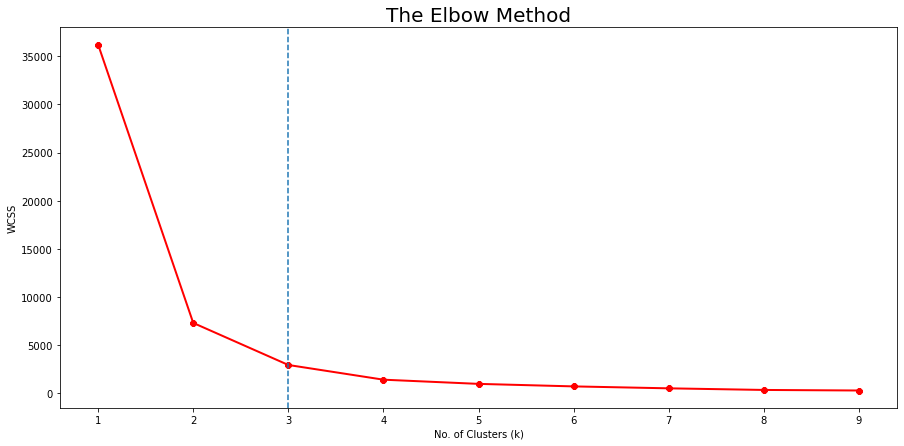

In [37]:
wcss=[]
clustering_data = RFM_table[['frequency']]
for i in range(1,10):
    km = KMeans(i)
    km.fit(clustering_data)
    wcss.append(km.inertia_)

    
    
fig, ax = plt.subplots(figsize=(15,7))
ax = plt.plot(range(1,10),wcss, linewidth=2, color="red", marker ="8")
plt.axvline(x=3, ls='--')
plt.ylabel('WCSS')
plt.xlabel('No. of Clusters (k)')
plt.title('The Elbow Method', fontsize = 20)
plt.show()    

In [38]:
# build 3 clusters for frequency and add it to dataframe
kmeans = KMeans(n_clusters=3)
kmeans.fit(RFM_table[['frequency']])
RFM_table['FrequencyCluster'] = kmeans.predict(RFM_table[['frequency']])

RFM_table = order_cluster('FrequencyCluster', 'frequency',RFM_table,True)

RFM_table

,UserID,recency,frequency,amount,RecencyCluster,FrequencyCluster
0,1503909,33,15,2.035901e+04,2,1
1,1503973,32,20,1.260000e+00,2,1
2,1504675,32,18,-6.762000e+02,2,1
3,1505256,33,16,3.152016e+06,2,1
4,1505263,33,17,-5.947000e+01,2,1
...,...,...,...,...,...,...
371,1515630,42,9,6.300000e+03,1,0
372,1515727,48,1,2.886100e+02,1,0
373,1515896,46,4,5.317200e+02,1,0
374,1516827,46,6,2.702797e+02,1,0


In [39]:
RFM_table.groupby('FrequencyCluster')['frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,114.0,3.666667,2.374893,1.0,2.0,3.0,5.0,9.0
1,103.0,15.067961,3.218397,10.0,13.0,15.0,18.0,20.0
2,159.0,25.981132,2.822764,21.0,23.5,26.0,28.0,30.0


#### Revenue Clusters 

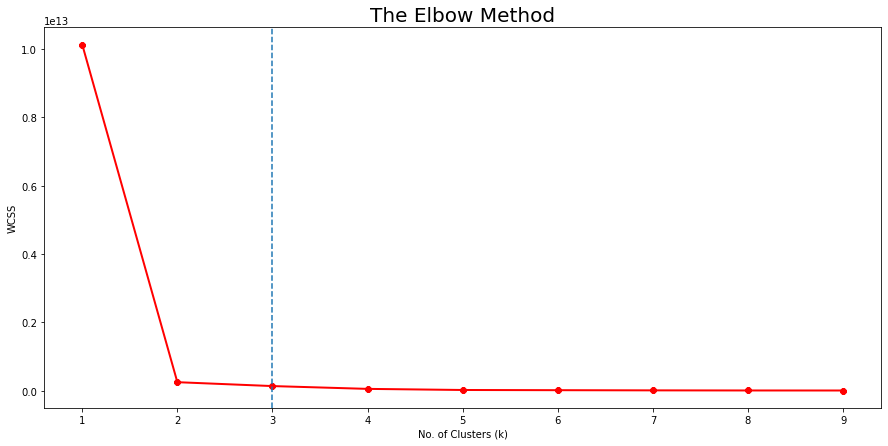

In [40]:
wcss=[]
clustering_data = RFM_table[['amount']]
for i in range(1,10):
    km = KMeans(i)
    km.fit(clustering_data)
    wcss.append(km.inertia_)

    
    
fig, ax = plt.subplots(figsize=(15,7))
ax = plt.plot(range(1,10),wcss, linewidth=2, color="red", marker ="8")
plt.axvline(x=3, ls='--')
plt.ylabel('WCSS')
plt.xlabel('No. of Clusters (k)')
plt.title('The Elbow Method', fontsize = 20)
plt.show()    

In [41]:
# build 3 clusters for revenue and add it to dataframe
kmeans = KMeans(n_clusters=3)
kmeans.fit(RFM_table[['amount']])
RFM_table['AmountCluster'] = kmeans.predict(RFM_table[['amount']])

RFM_table = order_cluster('AmountCluster', 'amount',RFM_table,True)

RFM_table

,UserID,recency,frequency,amount,RecencyCluster,FrequencyCluster,AmountCluster
0,1503909,33,15,2.035901e+04,2,1,1
1,1503973,32,20,1.260000e+00,2,1,1
2,1504675,32,18,-6.762000e+02,2,1,1
3,1505263,33,17,-5.947000e+01,2,1,1
4,1505559,32,11,-4.197805e+01,2,1,1
...,...,...,...,...,...,...,...
371,1515896,46,4,5.317200e+02,1,0,1
372,1516827,46,6,2.702797e+02,1,0,1
373,1521647,41,3,2.302860e+03,1,0,1
374,1505256,33,16,3.152016e+06,2,1,2


In [42]:
RFM_table.groupby('AmountCluster')['amount'].describe()

,count,mean,std,min,25%,50%,75%,max
AmountCluster,,,,,,,,
0,1.0,-3.333255e+05,NaN,-3.333255e+05,-3.333255e+05,-3.333255e+05,-3.333255e+05,-3.333255e+05
1,374.0,4.501033e+03,18887.648814,-3.997419e+04,-3.215475e+02,1.996500e+01,2.118973e+03,1.809613e+05
2,1.0,3.152016e+06,NaN,3.152016e+06,3.152016e+06,3.152016e+06,3.152016e+06,3.152016e+06


#### Overall Score 

In [43]:
#calculate overall score using the clusters of each metric and use mean to see details
RFM_table['Overall_RFM_Score'] = RFM_table['RecencyCluster'] + RFM_table['FrequencyCluster'] + RFM_table['AmountCluster']
RFM_table.groupby('Overall_RFM_Score')['recency','frequency','amount'].mean()

,recency,frequency,amount
Overall_RFM_Score,,,
0,60.000000,2.000000,-333325.526286
1,56.568182,2.250000,5113.865334
2,44.533333,4.600000,1673.869348
3,35.867925,6.471698,1700.958608
4,33.155556,15.711111,6240.980244
5,32.246835,25.981013,24736.309091


In [44]:
# function for creating customer classes based on the calculated overall score
def createCustomerClass(x):
    if x<=0 :
        return 'Low Value'
    elif x<=3:
        return 'Mid Value'
    else:
        return 'High Value'

RFM_table['Customer_Class'] = RFM_table['Overall_RFM_Score'].apply(lambda x: createCustomerClass(x))    

In [45]:
RFM_table

,UserID,recency,frequency,amount,RecencyCluster,FrequencyCluster,AmountCluster,Overall_RFM_Score,Customer_Class
0,1503909,33,15,2.035901e+04,2,1,1,4,High Value
1,1503973,32,20,1.260000e+00,2,1,1,4,High Value
2,1504675,32,18,-6.762000e+02,2,1,1,4,High Value
3,1505263,33,17,-5.947000e+01,2,1,1,4,High Value
4,1505559,32,11,-4.197805e+01,2,1,1,4,High Value
...,...,...,...,...,...,...,...,...,...
371,1515896,46,4,5.317200e+02,1,0,1,2,Mid Value
372,1516827,46,6,2.702797e+02,1,0,1,2,Mid Value
373,1521647,41,3,2.302860e+03,1,0,1,2,Mid Value
374,1505256,33,16,3.152016e+06,2,1,2,5,High Value


In [46]:
RFM_table['Customer_Class'].value_counts()

High Value    248
Mid Value     127
Low Value       1
Name: Customer_Class, dtype: int64

#### CLTV Prediction

In [47]:
# Calculate revenue per user for the second month
Revenue_Table = Second_Month.groupby('UserID').agg({'Hold': lambda x: x.sum()}) # Monetary 
Revenue_Table.rename(columns={'Hold': 'm2_value'}, inplace=True) 
Revenue_Table = Revenue_Table.reset_index()
Revenue_Table

,UserID,m2_value
0,1503909,15693.720000
1,1503973,182.070000
2,1503986,2641.610000
3,1504089,-447.510000
4,1504107,24248.640000
...,...,...
326,1522120,-344.800000
327,1522128,33114.240000
328,1522160,360.540000
329,1522218,1488.310000


In [48]:
# join RFM values with revenue from next month
Final_Table = pd.merge(RFM_table, Revenue_Table, left_on=['UserID'], right_on=['UserID'], how = 'left')
Final_Table = Final_Table.fillna(0)
Final_Table

,UserID,recency,frequency,amount,RecencyCluster,FrequencyCluster,AmountCluster,Overall_RFM_Score,Customer_Class,m2_value
0,1503909,33,15,2.035901e+04,2,1,1,4,High Value,15693.720000
1,1503973,32,20,1.260000e+00,2,1,1,4,High Value,182.070000
2,1504675,32,18,-6.762000e+02,2,1,1,4,High Value,-438.690000
3,1505263,33,17,-5.947000e+01,2,1,1,4,High Value,136.990000
4,1505559,32,11,-4.197805e+01,2,1,1,4,High Value,-276.073508
...,...,...,...,...,...,...,...,...,...,...
371,1515896,46,4,5.317200e+02,1,0,1,2,Mid Value,0.000000
372,1516827,46,6,2.702797e+02,1,0,1,2,Mid Value,0.000000
373,1521647,41,3,2.302860e+03,1,0,1,2,Mid Value,0.000000
374,1505256,33,16,3.152016e+06,2,1,2,5,High Value,-71781.450000


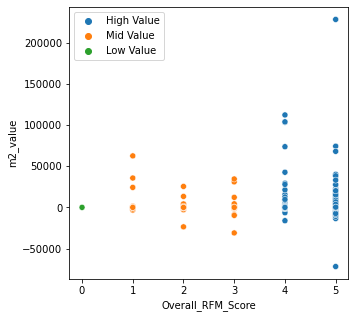

In [49]:
# scatter plot to identify correlation
graph = Final_Table[['Customer_Class', 'Overall_RFM_Score', 'm2_value']]

fig,ax = plt.subplots()
sns.scatterplot(data=graph, hue='Customer_Class', x='Overall_RFM_Score', y='m2_value')
plt.legend(loc=2)

plt.show()


In [50]:
# Then we will try to predict the revenue using the RFM metrics as predictors
Final_Table = Final_Table[['UserID', 'recency', 'frequency', 'amount', 'm2_value' ]] # keep only needed columns

# rename columns to clearly define that they refer to month 1
dict = {'recency': 'm1_recency',
        'frequency': 'm1_frequency',
        'amount': 'm1_amount'}

Final_Table.rename(columns=dict,inplace=True)


Final_Table


,UserID,m1_recency,m1_frequency,m1_amount,m2_value
0,1503909,33,15,2.035901e+04,15693.720000
1,1503973,32,20,1.260000e+00,182.070000
2,1504675,32,18,-6.762000e+02,-438.690000
3,1505263,33,17,-5.947000e+01,136.990000
4,1505559,32,11,-4.197805e+01,-276.073508
...,...,...,...,...,...
371,1515896,46,4,5.317200e+02,0.000000
372,1516827,46,6,2.702797e+02,0.000000
373,1521647,41,3,2.302860e+03,0.000000
374,1505256,33,16,3.152016e+06,-71781.450000


In [51]:
# bring some additional columns to use as predictors in the model

additional_columns = First_Month[['UserProfileId','IsJackpotWinID', 'IsFreeSpinID', 'IsLiveID']]

additional_columns_groupby = additional_columns.groupby(['UserProfileId']) 

additional_columns_group = additional_columns_groupby.agg(Total_Jackpot_Win=pd.NamedAgg(column="IsJackpotWinID", aggfunc='sum'),
                                                      Total_FreeSpin=pd.NamedAgg(column="IsFreeSpinID", aggfunc='sum'),
                                                      Total_Live=pd.NamedAgg(column="IsLiveID", aggfunc='sum')
                                                      )


additional_columns_group = additional_columns_group.reset_index()

dict = {'Total_Jackpot_Win': 'm1_Total_Jackpot_Win',
        'Total_FreeSpin': 'm1_Total_FreeSpin',
        'Total_Live': 'm1_Total_Live'}

additional_columns_group.rename(columns=dict,inplace=True)

additional_columns_group


,UserProfileId,m1_Total_Jackpot_Win,m1_Total_FreeSpin,m1_Total_Live
0,1503909,0,4,0
1,1503973,0,18,0
2,1503986,0,26,0
3,1504041,0,4,3
4,1504089,0,28,1
...,...,...,...,...
371,1522128,0,11,2
372,1522160,0,28,4
373,1522218,0,18,2
374,1522269,0,0,0


In [52]:
# add the new columns to the dataset
Final_Table = pd.merge(Final_Table, additional_columns_group, left_on=['UserID'], right_on=['UserProfileId'], how = 'left')

# keep only needed columns
Final_Table = Final_Table[['m1_recency', 'm1_frequency', 'm1_amount', 'm1_Total_Jackpot_Win', 'm1_Total_FreeSpin', 'm1_Total_Live', 'm2_value']]
Final_Table

,m1_recency,m1_frequency,m1_amount,m1_Total_Jackpot_Win,m1_Total_FreeSpin,m1_Total_Live,m2_value
0,33,15,2.035901e+04,0,4,0,15693.720000
1,32,20,1.260000e+00,0,18,0,182.070000
2,32,18,-6.762000e+02,0,20,7,-438.690000
3,33,17,-5.947000e+01,0,17,5,136.990000
4,32,11,-4.197805e+01,0,11,0,-276.073508
...,...,...,...,...,...,...,...
371,46,4,5.317200e+02,0,4,1,0.000000
372,46,6,2.702797e+02,0,1,2,0.000000
373,41,3,2.302860e+03,0,2,3,0.000000
374,33,16,3.152016e+06,0,2,15,-71781.450000


In [53]:
# remove outliers using IQR
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

Final_Table = remove_outlier(Final_Table, 'm2_value')

Final_Table

,m1_recency,m1_frequency,m1_amount,m1_Total_Jackpot_Win,m1_Total_FreeSpin,m1_Total_Live,m2_value
1,32,20,1.260000,0,18,0,182.070000
2,32,18,-676.200000,0,20,7,-438.690000
3,33,17,-59.470000,0,17,5,136.990000
4,32,11,-41.978051,0,11,0,-276.073508
5,32,18,2698.500000,0,14,2,-1234.500000
...,...,...,...,...,...,...,...
370,48,1,288.610000,0,0,0,0.000000
371,46,4,531.720000,0,4,1,0.000000
372,46,6,270.279735,0,1,2,0.000000
373,41,3,2302.860000,0,2,3,0.000000


In [54]:
Final_Table['m2_value'].describe()

count     281.000000
mean       83.263819
std       828.787197
min     -2313.360000
25%      -247.380000
50%         0.000000
75%       159.720000
max      3426.140419
Name: m2_value, dtype: float64

In [55]:
Final_Table

,m1_recency,m1_frequency,m1_amount,m1_Total_Jackpot_Win,m1_Total_FreeSpin,m1_Total_Live,m2_value
1,32,20,1.260000,0,18,0,182.070000
2,32,18,-676.200000,0,20,7,-438.690000
3,33,17,-59.470000,0,17,5,136.990000
4,32,11,-41.978051,0,11,0,-276.073508
5,32,18,2698.500000,0,14,2,-1234.500000
...,...,...,...,...,...,...,...
370,48,1,288.610000,0,0,0,0.000000
371,46,4,531.720000,0,4,1,0.000000
372,46,6,270.279735,0,1,2,0.000000
373,41,3,2302.860000,0,2,3,0.000000


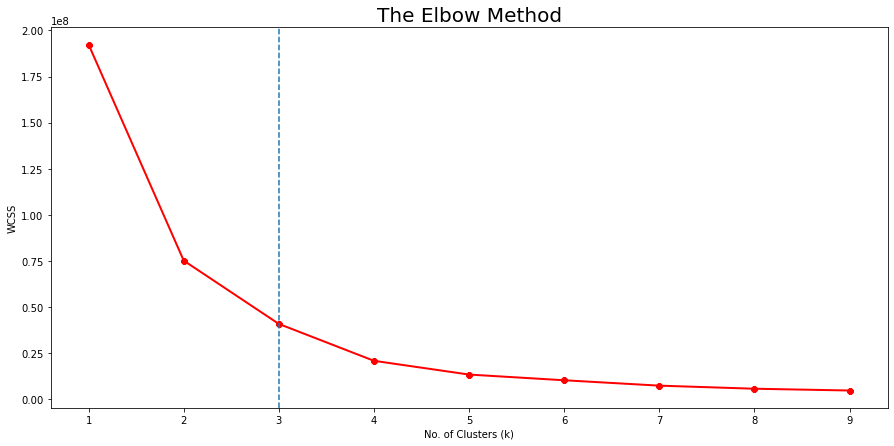

In [56]:
# multiclass classification approach



# find the optimal number of clusters for the m2_value

wcss=[]
clustering_data = Final_Table[['m2_value']]
for i in range(1,10):
    km = KMeans(i)
    km.fit(clustering_data)
    wcss.append(km.inertia_)

    
    
fig, ax = plt.subplots(figsize=(15,7))
ax = plt.plot(range(1,10),wcss, linewidth=2, color="red", marker ="8")
plt.axvline(x=3, ls='--')
plt.ylabel('WCSS')
plt.xlabel('No. of Clusters (k)')
plt.title('The Elbow Method', fontsize = 20)
plt.show()    

In [57]:
#creating 3 clusters
kmeans = KMeans(n_clusters=3)
Final_Table['m2_LTVCluster'] = kmeans.fit_predict(Final_Table[['m2_value']])

Final_Table.head()

,m1_recency,m1_frequency,m1_amount,m1_Total_Jackpot_Win,m1_Total_FreeSpin,m1_Total_Live,m2_value,m2_LTVCluster
1,32,20,1.260000,0,18,0,182.070000,0
2,32,18,-676.200000,0,20,7,-438.690000,0
3,33,17,-59.470000,0,17,5,136.990000,0
4,32,11,-41.978051,0,11,0,-276.073508,0
5,32,18,2698.500000,0,14,2,-1234.500000,2


In [58]:
#order cluster number based on LTV
Final_Table = order_cluster('m2_LTVCluster', 'm2_value',Final_Table,True)

#creatinga new cluster dataframe
Final_Table_cluster = Final_Table.copy()

#see details of the clusters
Final_Table_cluster.groupby('m2_LTVCluster')['m2_value'].describe() 



,count,mean,std,min,25%,50%,75%,max
m2_LTVCluster,,,,,,,,
0,31.0,-1164.968392,481.110294,-2313.360000,-1508.810000,-969.570000,-773.315,-612.700000
1,211.0,-30.216274,245.568225,-577.742845,-169.355000,0.000000,0.000,804.310000
2,39.0,1689.404799,745.075762,851.020000,1027.812046,1449.731822,2303.600,3426.140419


In [59]:
# drop m2_value since we are going to use the cluster created from that value
Final_Table_cluster.drop('m2_value', axis=1, inplace=True)
Final_Table_cluster

,m1_recency,m1_frequency,m1_amount,m1_Total_Jackpot_Win,m1_Total_FreeSpin,m1_Total_Live,m2_LTVCluster
0,32,20,1.260000,0,18,0,1
1,32,18,-676.200000,0,20,7,1
2,33,17,-59.470000,0,17,5,1
3,32,11,-41.978051,0,11,0,1
4,32,17,-321.750000,0,20,0,1
...,...,...,...,...,...,...,...
276,58,4,142.800000,0,3,5,2
277,41,3,239.904707,0,2,0,2
278,44,4,-2101.611898,0,1,0,2
279,47,7,1888.658491,0,1,0,2


In [60]:
num_cols = [ 'm1_recency',
           'm1_frequency',
           'm1_amount',
           'm1_Total_Jackpot_Win',
           'm1_Total_FreeSpin',
            'm1_Total_Live'
        ]


scaler = preprocessing.MinMaxScaler()
Final_Table_cluster[num_cols] = scaler.fit_transform(Final_Table_cluster[num_cols])
Final_Table_cluster.head()

,m1_recency,m1_frequency,m1_amount,m1_Total_Jackpot_Win,m1_Total_FreeSpin,m1_Total_Live,m2_LTVCluster
0,0.000000,0.655172,0.691083,0.0,0.486486,0.000000,1
1,0.000000,0.586207,0.689678,0.0,0.540541,0.184211,1
2,0.034483,0.551724,0.690957,0.0,0.459459,0.131579,1
3,0.000000,0.344828,0.690993,0.0,0.297297,0.000000,1
4,0.000000,0.551724,0.690413,0.0,0.540541,0.000000,1


In [61]:
Final_Table_cluster['m2_LTVCluster'].value_counts()

1    211
2     39
0     31
Name: m2_LTVCluster, dtype: int64

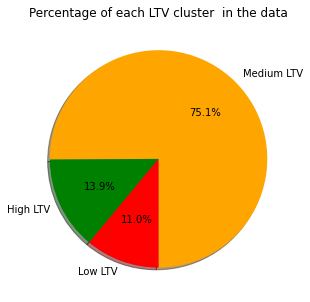

In [62]:
# Create plot with the percentage of cluster
sizes = Final_Table_cluster['m2_LTVCluster'].value_counts(sort = True)
colors = ["orange","green","red"] 
rcParams['figure.figsize'] = 5,5
labels = 'Medium LTV','High LTV', 'Low LTV'      

plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=270,)
plt.title('Percentage of each LTV cluster  in the data')
plt.show()

In [63]:
# Classes are unbalanced, High and Low LTV classes have a combined share 3 times lower than Medium class

In [64]:
## Train Test Split
targetVariable = 'm2_LTVCluster'

X=Final_Table_cluster.drop([targetVariable], axis=1)
y=Final_Table_cluster[targetVariable]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

class_w = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)

### XGBoost 

In [65]:
xgb = XGBClassifier(n_estimators=500,
                    objective='multi:softmax',
                    num_class=10,
                    max_depth=10,
                    learning_rate=0.1,
                    eta=0.1,
                    num_round = 20,
                    class_weight=class_w)
training_start = time.perf_counter()
xgb.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = xgb.predict(X_test)
prediction_end = time.perf_counter()
acc_xgb = (preds == y_test).sum().astype(float) / len(preds)*100
xgb_train_time = training_end-training_start
xgb_prediction_time = prediction_end-prediction_start
print("XGBoost's prediction accuracy is: %3.2f" % (acc_xgb))
print("Time consumed for training: %4.3f" % (xgb_train_time))
print("Time consumed for prediction: %6.5f seconds" % (xgb_prediction_time))

[17:47:40] WARNING: ..\src\learner.cc:576: 
Parameters: { "class_weight", "num_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:47:40] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost's prediction accuracy is: 69.41
Time consumed for training: 0.406
Time consumed for prediction: 0.00407 seconds


In [66]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.50      0.23      0.32        13
           1       0.77      0.89      0.82        61
           2       0.22      0.18      0.20        11

    accuracy                           0.69        85
   macro avg       0.50      0.43      0.45        85
weighted avg       0.66      0.69      0.67        85



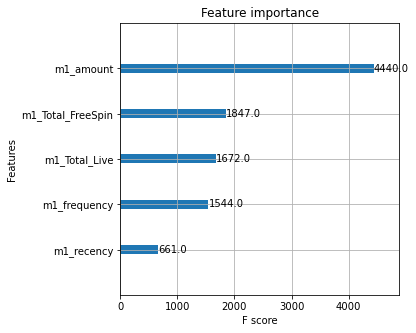

In [67]:
plot_importance(xgb)
pyplot.show()

In [68]:
d = {'y_Predicted': preds,'y_Actual': y_test}

matrix = pd.DataFrame(d, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(matrix['y_Actual'], matrix['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
print (confusion_matrix)

Predicted  0   1  2
Actual             
0          3   8  2
1          2  54  5
2          1   8  2


### Random Forest 

In [69]:
rfc = RandomForestClassifier(n_estimators=200,class_weight='balanced')
training_start = time.perf_counter()
rfc.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = rfc.predict(X_test)
prediction_end = time.perf_counter()
acc_rfc = (preds == y_test).sum().astype(float) / len(preds)*100
rfc_train_time = training_end-training_start
rfc_prediction_time = prediction_end-prediction_start
print("Random Forest Classifier's prediction accuracy is: %3.2f" % (acc_rfc))
print("Time consumed for training: %4.3f seconds" % (rfc_train_time))
print("Time consumed for prediction: %6.5f seconds" % (rfc_prediction_time))

Random Forest Classifier's prediction accuracy is: 72.94
Time consumed for training: 0.183 seconds
Time consumed for prediction: 0.01466 seconds


In [70]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.67      0.15      0.25        13
           1       0.75      0.97      0.84        61
           2       0.33      0.09      0.14        11

    accuracy                           0.73        85
   macro avg       0.58      0.40      0.41        85
weighted avg       0.68      0.73      0.66        85



Text(0.5, 0, 'Relative Importance')

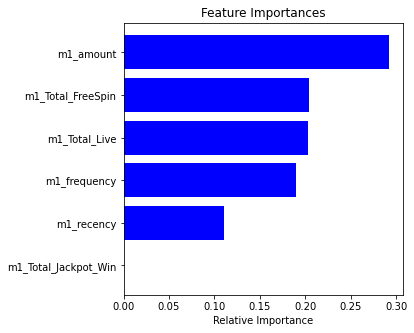

In [71]:
features=X_test.columns
importances = rfc.feature_importances_
indices = np.argsort(importances)

plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')

In [72]:
d = {'y_Predicted': preds,'y_Actual': y_test}

matrix = pd.DataFrame(d, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(matrix['y_Actual'], matrix['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
print (confusion_matrix)

Predicted  0   1  2
Actual             
0          2  10  1
1          1  59  1
2          0  10  1


### KNN 

The optimal number of neighbors is 7


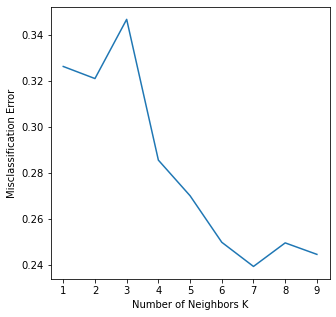

In [73]:
neighbors = list(range(1,10))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())
    
    
# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print ("The optimal number of neighbors is %d" % optimal_k)

#plot misclassification error vs k
plt.plot(neighbors, MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show() 

In [74]:
knn = KNeighborsClassifier(n_neighbors=optimal_k)
training_start = time.perf_counter()
knn.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = knn.predict(X_test)
prediction_end = time.perf_counter()
acc_knn = (preds == y_test).sum().astype(float) / len(preds)*100
knn_train_time = training_end-training_start
knn_prediction_time = prediction_end-prediction_start
print("KNN Classifier's prediction accuracy is: %3.2f" % (acc_knn))
print("Time consumed for training: %4.3f seconds" % (knn_train_time))
print("Time consumed for prediction: %6.5f seconds" % (knn_prediction_time))

KNN Classifier's prediction accuracy is: 71.76
Time consumed for training: 0.002 seconds
Time consumed for prediction: 0.00395 seconds


In [75]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       1.00      0.08      0.14        13
           1       0.74      0.98      0.85        61
           2       0.00      0.00      0.00        11

    accuracy                           0.72        85
   macro avg       0.58      0.35      0.33        85
weighted avg       0.68      0.72      0.63        85



In [76]:
d = {'y_Predicted': preds,'y_Actual': y_test}

matrix = pd.DataFrame(d, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(matrix['y_Actual'], matrix['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
print (confusion_matrix)

Predicted  0   1  2
Actual             
0          1  10  2
1          0  60  1
2          0  11  0


In [77]:
results = pd.DataFrame({'Model': ['XGBClassifier', 'Random Forest', 'K-Neighbors'],
                        'Accuracy': [acc_xgb, acc_rfc, acc_knn],
                        'Precision': [0.66, 0.68, 0.68],
                        'Recall': [0.69, 0.73, 0.72],
                        'F1-Score': [ 0.67, 0.66, 0.63],
                        'Runtime Training': [xgb_train_time, rfc_train_time, knn_train_time],
                        'Runtime Prediction': [xgb_prediction_time, rfc_prediction_time,knn_prediction_time]})
result_df = results.sort_values(by='Accuracy', ascending=False)
result_df = result_df.set_index('Model')
result_df

,Accuracy,Precision,Recall,F1-Score,Runtime Training,Runtime Prediction
Model,,,,,,
Random Forest,72.941176,0.68,0.73,0.66,0.182905,0.014661
K-Neighbors,71.764706,0.68,0.72,0.63,0.001750,0.003952
XGBClassifier,69.411765,0.66,0.69,0.67,0.406462,0.004075
